Số quan sát: 40

ADF Statistic: 6.311456094847122
p-value: 1.0
Chuỗi KHÔNG dừng → sai phân bậc 1
Train samples: 31
Test samples : 8

===== TÓM TẮT MÔ HÌNH =====
                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   31
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -730.451
Date:                Fri, 16 Jan 2026   AIC                           1466.903
Time:                        00:00:51   BIC                           1471.106
Sample:                             0   HQIC                          1468.247
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1652      0.157      1.053      

C:\Users\hienn\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\hienn\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\hienn\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\hienn\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_mode

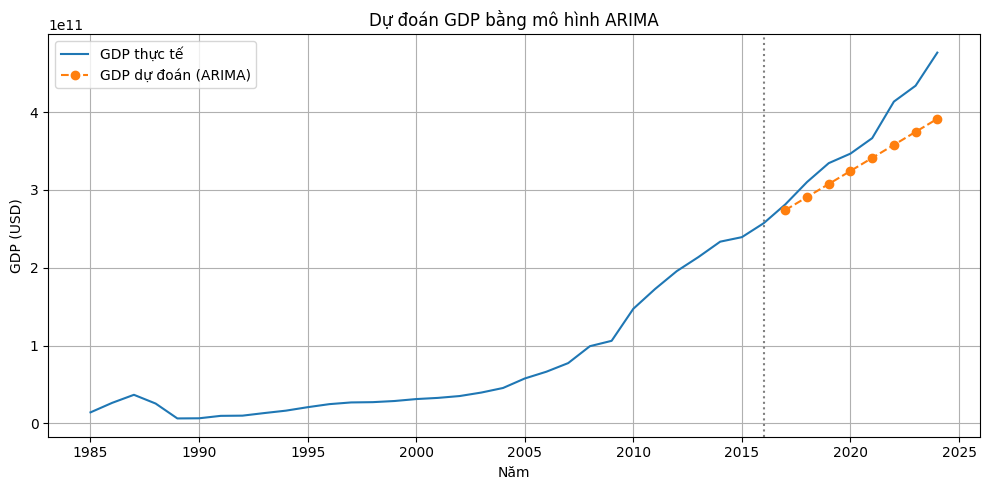

In [6]:
# ===== ARIMA DỰ ĐOÁN GDP =====

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. LOAD DATA
df = pd.read_csv("macro_vietnam_processed.csv")

df["Year"] = pd.to_numeric(df["Year"])
df = df.sort_values("Year").reset_index(drop=True)

gdp = df["GDP"].astype(float)

print("Số quan sát:", len(gdp))

# 2. KIỂM TRA TÍNH DỪNG (ADF TEST)
adf_result = adfuller(gdp)
print("\nADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

# Nếu không dừng → sai phân bậc 1
if adf_result[1] > 0.05:
    print("Chuỗi KHÔNG dừng → sai phân bậc 1")
    gdp_diff = gdp.diff().dropna()
    d = 1
else:
    print("Chuỗi DỪNG")
    gdp_diff = gdp
    d = 0

# 3. TRAIN / TEST SPLIT (80% / 20%)
train_size = int(len(gdp_diff) * 0.8)
train = gdp_diff.iloc[:train_size]
test  = gdp_diff.iloc[train_size:]

print("Train samples:", len(train))
print("Test samples :", len(test))

# 4. HUẤN LUYỆN ARIMA
# (p, d, q) = (1, d, 1) → ổn định cho chuỗi GDP
model = ARIMA(train, order=(1, d, 1))
model_fit = model.fit()

print("\n===== TÓM TẮT MÔ HÌNH =====")
print(model_fit.summary())

# 5. DỰ ĐOÁN
forecast_diff = model_fit.forecast(steps=len(test))

# Nếu có sai phân → hoàn nguyên GDP
if d == 1:
    last_gdp = gdp.iloc[train_size]
    forecast = last_gdp + forecast_diff.cumsum()
    actual = gdp.iloc[train_size+1:]
else:
    forecast = forecast_diff
    actual = test

# 6. ĐÁNH GIÁ
mae  = mean_absolute_error(actual, forecast)
rmse = np.sqrt(mean_squared_error(actual, forecast))
r2   = r2_score(actual, forecast)

print("\n===== ĐÁNH GIÁ ARIMA (GDP) =====")
print(f"MAE  = {mae:,.0f} USD")
print(f"RMSE = {rmse:,.0f} USD")
print(f"R²   = {r2:.4f}")

# 7. BIỂU ĐỒ
plt.figure(figsize=(10,5))
plt.plot(df["Year"], gdp, label="GDP thực tế")
plt.plot(df["Year"].iloc[train_size+1:], forecast, 
         linestyle="--", marker="o", label="GDP dự đoán (ARIMA)")
plt.axvline(df["Year"].iloc[train_size], color="gray", linestyle=":")
plt.xlabel("Năm")
plt.ylabel("GDP (USD)")
plt.title("Dự đoán GDP bằng mô hình ARIMA")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
